In [2]:
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from my_ml_package.classification import sigmoid, logistic_regression_for_multiclass, lr_predict_multiclass
import numpy as np

In [3]:
X, y = datasets.load_iris(return_X_y=True)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regularization on MLE-based Algorithms

### MLE on Iris Data

In [4]:
X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

W, b = logistic_regression_for_multiclass(X_train, y_train, num_iter=10000, lr=0.01)
y_train_pred = lr_predict_multiclass(X_train, W, b)
print(f"Train Accuracy: {np.mean(y_train_pred == y_train)}")
y_test_pred = lr_predict_multiclass(X_test, W, b)
print(f"Test Accuracy: {np.mean(y_test_pred == y_test)}")


Train Accuracy: 0.9583333333333334
Test Accuracy: 1.0


According to this result, do we need regularization?

In [4]:
# cross validation
kf = KFold(n_splits=5)
train_accs = []
test_accs = []
W, b = None, None
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    W, b = logistic_regression_for_multiclass(X_train, y_train, W=W, b=b, num_iter=10000, lr=0.01)
    y_pred = lr_predict_multiclass(X_test, W, b)
    test_accs.append(np.mean(y_pred == y_test))
    y_pred = lr_predict_multiclass(X_train, W, b)
    train_accs.append(np.mean(y_pred == y_train))
print(f"Train Accuracy: {np.mean(train_accs)}")
print(f"Test Accuracy: {np.mean(test_accs)}")


Train Accuracy: 0.97
Test Accuracy: 0.8666666666666666


In [5]:
# clf = LogisticRegression(penalty=None, max_iter=10000, solver='sag')
# clf.fit(X, y)
# y_pred = clf.predict(X)
# print(f"Accuracy: {np.mean(y_pred == y)}")

#### Regularization
* The second term : maximize Pr(parameters|data) $\propto$ Pr(data|parameters) * Pr(parameters)
    * Bias (fit the training data) and Variance (generalize to predict unseen data points)
    * Reducing Model Complexity

* L1, L2 Regularization 
    * Lasso (L1) and Ridge (L2) for linear regression
    * Regularization for logistic regression
    <!-- <center><img src="pics/l1_l2_on_logistic_regression.png" width="500"></center> -->
    * L1 tends to perform better when only a small number of predictor variables are significant, as it can remove insignificant variables completely from the model

In [5]:
# make a function
def cross_val_logistic_regression_for_multiclass(X, y,n_splits=5, num_iter=10000, lr=0.01,  reg_lambda=0, reg_type=None):
    kf = KFold(n_splits=n_splits)
    train_accs = []
    test_accs = []
    W, b = None, None
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        W, b = logistic_regression_for_multiclass(X_train, y_train, W=W, b=b, num_iter=num_iter, lr=lr, reg_lambda=reg_lambda, reg_type=reg_type)
        y_pred = lr_predict_multiclass(X_test, W, b)
        test_accs.append(np.mean(y_pred == y_test))
        y_pred = lr_predict_multiclass(X_train, W, b)
        train_accs.append(np.mean(y_pred == y_train))
    print(f"Train Accuracy: {np.mean(train_accs)}")
    print(f"Test Accuracy: {np.mean(test_accs)}")
    return W, b

In [15]:
cross_val_logistic_regression_for_multiclass(X, y, num_iter=10000, lr=0.01, reg_lambda=0, reg_type=None)

Train Accuracy: 0.97
Test Accuracy: 0.8666666666666666


(array([[ 0.71981715,  0.35582151, -3.49467556],
        [ 2.46421622, -2.48993422, -3.3539143 ],
        [-3.86176297,  1.36851805,  4.87029922],
        [-1.74372538, -2.57774201,  5.49126005]]),
 array([ 0.4518733 ,  3.04019345, -2.83230436]))

In [14]:
cross_val_logistic_regression_for_multiclass(X, y, num_iter=10000, lr=0.01, reg_lambda=0.4, reg_type='l1')

Train Accuracy: 0.9650000000000001
Test Accuracy: 0.8666666666666666


(array([[ 0.28735606,  0.25228065, -2.75008419],
        [ 2.2785291 , -2.26858123, -2.52263279],
        [-3.24243225,  1.12733364,  3.88824037],
        [-0.65391112, -1.88496985,  4.47965458]]),
 array([ 0.80421564,  3.07301192, -3.13956715]))

In [10]:
cross_val_logistic_regression_for_multiclass(X, y, num_iter=10000, lr=0.01, reg_lambda=0.4, reg_type='l2')

Train Accuracy: 0.9533333333333334
Test Accuracy: 0.8466666666666667


(array([[ 0.43838856,  0.24170703, -1.87530519],
        [ 1.7082025 , -2.15454261, -1.7892671 ],
        [-2.70684493,  1.01978311,  2.93729314],
        [-1.22218904, -1.61095949,  3.0281595 ]]),
 array([ 0.76241046,  2.88140385, -3.43641507]))

### Why Does Smaller Weights Reduce Overfitting?
Smaller weights lead to smoother model predictions that change more gradually with input changes. This smoothness means that the model is less sensitive to the small fluctuations in data, which might just be noise in the training set.

### L1 will Push $\beta$ to Zero
<!-- 1. L2 Regularization Term: The regularization term for $\mathrm{L} 2$ regularization is $\lambda \sum w_i^2$, where $w_i$ are the coefficients and $\lambda$ is the regularization strength.
- The derivative (or gradient) of the $\mathrm{L} 2$ regularization term with respect to a coefficient $w_i$ is $2 \lambda w_i$. This derivative shows how the penalty changes with respect to a small change in the coefficient.
- The key aspect here is that the gradient $2 \lambda w_i$ is proportional to the value of $w_i$ itself. As $w_i$ approaches zero, the gradient also approaches zero. This means that as the coefficient gets smaller, the force pushing it further towards zero diminishes. Consequently, the coefficient is shrunk towards zero but never exactly reaches zero unless it starts at zero.
2. L1 Regularization Term: The gradient (or subgradient, technically) of the regularization term is a constant $\lambda$ (or $-\lambda$ depending on the sign of $w_i$ ) regardless of the magnitude of $w_i$ except exactly at zero, where it is undefined but constrained within $[-\lambda, \lambda]$. This characteristic of L1 leads to coefficients being exactly zeroed out because any small coefficient $w_i$ where the contribution to the model prediction is less than the fixed penalty $\lambda$ becomes zero in the optimization process. This produces the sparse solutions characteristic of L1 regularization. -->

In [33]:
# weights
print("Weights with L2 regularization")
print(W_l2)
print("Weights with L1 regularization")
print(W_l1)

Weights with L2 regularization
[[ 0.26714577 -0.02274114 -0.67798989]
 [ 0.91860382 -0.58463158 -0.73299136]
 [-1.46965364  0.33010913  1.10630081]
 [-0.66477688 -0.13358578  0.79099894]]
Weights with L1 regularization
[[ 2.26977128e-01  8.36157513e-04 -6.09559321e-01]
 [ 8.72387225e-01 -5.54066010e-01 -6.62981270e-01]
 [-1.39031542e+00  2.49819589e-01  1.01629440e+00]
 [-5.61609128e-01 -3.81686364e-02  6.87644588e-01]]


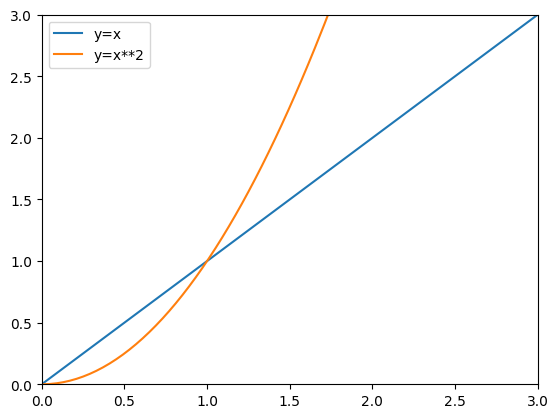

In [29]:
# plot lines y = x and y = x**2
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-10, 10, 1000)
y = x
y2 = x**2
plt.plot(x, y, label='y=x')
plt.plot(x, y2, label='y=x**2')
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.legend()
plt.show()

## Regularization on KNN
Model complexity:  
Larger k = smoother decision boundary = less complex model  
Overfitting: complex models run the risk of being sensitive to noise in the specific data rather than reflecting the genral trend in the data  
Underfitting  

In [ ]:
## Plot model complexity curves



def find_k(X_train, X_test, y_train, y_test, distance_type='euclidean'):
    # Setup arrays to store train and test accuracies
    neighbors = np.arange(1, 9)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))

    # Loop over different values of k
    for i, k in enumerate(neighbors):
        # Setup a k-NN Classifier with k neighbors: knn
        knn = KNeighborsClassifier(n_neighbors=k, metric=distance_type)

        # Fit the classifier to the training data
        knn.fit(X_train, y_train)
        
        #Compute accuracy on the training set
        train_accuracy[i] = knn.score(X_train, y_train)

        #Compute accuracy on the testing set
        test_accuracy[i] = knn.score(X_test, y_test)

    # Find sweet spot on the plot
    plt.title('k-NN: Varying Number of Neighbors')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

find_k(X_train, X_test, y_train, y_test, distance_type=distance_types[5])